In [1]:
import glob
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as tc
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import numba
from tqdm import tqdm
from tqdm import trange

warnings.filterwarnings(action='ignore')


In [2]:
def get_dataframe_from_dir(path, ext, ignore_idx=False, save_file=False):
    df = pd.DataFrame()
    if ext != 'csv':
        return df
    
    csv_files = glob.glob(path + f"/*.{ext}")
    df_list = (pd.read_csv(file) for file in csv_files)
    get_next = peek(df_list)

    if get_next is None:
        print("***** empty dataframe *****")
        return df
    
    df = pd.concat(df_list, ignore_index=ignore_idx)
    if save_file:
        df.to_csv('merged.csv')
    if 'time' in df.columns:
        df.set_index("time", drop=True, append=False, inplace=True)
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    else:
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    
    return df


In [3]:
def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first, itertools.chain([first], iterable)

In [6]:
df = get_dataframe_from_dir("../__data__/xaiops_metric/was/214(04.01~07.10)", "csv", save_file=True)
# df = df.sample(frac=0.01)

# remove low variance column
for column in df.columns:
    if df[column].mean() == 0:
        df.drop(columns=[column], inplace=True)

# remove rows having NaN value
df.dropna(axis=0, inplace=True)

# sort index
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143908 entries, 2022-04-01 00:00:00 to 2022-07-10 23:59:00
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   active_db_conn_count  143908 non-null  float64
 1   active_tx_count       143908 non-null  float64
 2   active_users          143908 non-null  float64
 3   call_count            143908 non-null  float64
 4   cpu_time              143908 non-null  float64
 5   cpu_usage             143908 non-null  float64
 6   db_sessions           143908 non-null  float64
 7   fetch_count           143908 non-null  float64
 8   fgc                   143908 non-null  float64
 9   fgct                  143908 non-null  float64
 10  file_count            143908 non-null  float64
 11  gc_count              143908 non-null  float64
 12  gc_time               143908 non-null  float64
 13  heap_usage            143908 non-null  float64
 14  jvm_free_heap         1439

In [8]:
df.describe()

,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
count,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,...,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000
mean,0.348671,6.116735,1.123234,10.235244,2.639522,1.714815,8.978568,28.625452,0.008777,1.226144,...,63.995737,199.173090,63.995737,694.231591,1.031402,9.384380,143.778884,9.979260,1.022626,8.158237
std,0.855621,35.363078,0.432208,8.803050,3.062439,1.482093,0.332399,25.889013,0.019025,2.671285,...,56.854849,797.986026,56.854849,1233.171588,0.670284,6.831776,42.934727,8.751367,0.663397,5.422465
min,0.000000,0.000000,0.000000,0.000000,0.144000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.600000,0.000000,0.000000,0.000000
25%,0.000000,0.150000,0.800000,2.650000,0.483000,0.300000,9.000000,6.100000,0.000000,0.000000,...,13.650000,29.284600,13.650000,85.450000,0.350000,2.450000,119.950000,2.449900,0.300000,2.350000
50%,0.100000,0.550000,1.200000,8.950000,0.900500,1.600000,9.000000,24.500000,0.000000,0.000000,...,55.200000,35.963400,55.200000,292.000000,1.150000,10.050000,142.000000,8.666600,1.150000,9.400000
75%,0.300000,2.000000,1.450000,14.900000,4.475000,2.650000,9.000000,42.150000,0.000000,0.000000,...,94.650000,64.528375,94.650000,760.512500,1.600000,14.050000,155.450000,14.600000,1.600000,13.000000
max,8.700000,300.000000,2.100000,57.100000,14.845000,11.550000,9.800000,217.950000,0.166667,24.333333,...,315.250000,141017.833300,315.250000,79966.600000,14.833300,154.500000,406.000000,48.699900,14.666667,130.166667


In [9]:
df.index

Index(['2022-04-01 00:00:00', '2022-04-01 00:01:00', '2022-04-01 00:02:00',
       '2022-04-01 00:03:00', '2022-04-01 00:04:00', '2022-04-01 00:05:00',
       '2022-04-01 00:06:00', '2022-04-01 00:07:00', '2022-04-01 00:08:00',
       '2022-04-01 00:09:00',
       ...
       '2022-07-10 23:50:00', '2022-07-10 23:51:00', '2022-07-10 23:52:00',
       '2022-07-10 23:53:00', '2022-07-10 23:54:00', '2022-07-10 23:55:00',
       '2022-07-10 23:56:00', '2022-07-10 23:57:00', '2022-07-10 23:58:00',
       '2022-07-10 23:59:00'],
      dtype='object', name='time', length=143908)

In [10]:
def get_threshold(m, std):
    upper = m + 3*std
    lower = m - 3*std
    return upper, lower


In [24]:
static_values = {}
columns = df.columns
for column in columns:
    if column not in static_values:
        static_values[column] = {}
    
    mean = df[column].mean()
    std = df[column].std()
    var = df[column].var()
    static_values[column]['mean'] = mean
    static_values[column]['std'] = std
    threshold = get_threshold(mean, std)
    static_values[column]['upper'] = threshold[0]
    static_values[column]['lower'] = threshold[1]
    static_values[column]['var'] = var

list(static_values.items())[:3]
list(static_values.items())[-3:]
# dict(itertools.islice(static_values.items(), 2))


[('tps',
  {'mean': 9.979260191233287,
   'std': 8.751366933372037,
   'upper': 36.2333609913494,
   'lower': -16.274840608882823,
   'var': 76.5864232025175}),
 ('ygc',
  {'mean': 1.022625875173336,
   'std': 0.6633973000293397,
   'upper': 3.0128177752613547,
   'lower': -0.9675660249146831,
   'var': 0.44009597768621783}),
 ('ygct',
  {'mean': 8.158236782450516,
   'std': 5.4224653795526,
   'upper': 24.425632921108317,
   'lower': -8.109159356207286,
   'var': 29.40313079244652})]

In [25]:
if 'is_anomaly' not in df:
    df.insert(len(columns), 'is_anomaly', 0, allow_duplicates=False)
else:
    df['is_anomaly'] = 0

In [26]:
df.describe()

,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct,is_anomaly
count,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,...,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.0
mean,0.348671,6.116735,1.123234,10.235244,2.639522,1.714815,8.978568,28.625452,0.008777,1.226144,...,199.173090,63.995737,694.231591,1.031402,9.384380,143.778884,9.979260,1.022626,8.158237,0.0
std,0.855621,35.363078,0.432208,8.803050,3.062439,1.482093,0.332399,25.889013,0.019025,2.671285,...,797.986026,56.854849,1233.171588,0.670284,6.831776,42.934727,8.751367,0.663397,5.422465,0.0
min,0.000000,0.000000,0.000000,0.000000,0.144000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,39.600000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.150000,0.800000,2.650000,0.483000,0.300000,9.000000,6.100000,0.000000,0.000000,...,29.284600,13.650000,85.450000,0.350000,2.450000,119.950000,2.449900,0.300000,2.350000,0.0
50%,0.100000,0.550000,1.200000,8.950000,0.900500,1.600000,9.000000,24.500000,0.000000,0.000000,...,35.963400,55.200000,292.000000,1.150000,10.050000,142.000000,8.666600,1.150000,9.400000,0.0
75%,0.300000,2.000000,1.450000,14.900000,4.475000,2.650000,9.000000,42.150000,0.000000,0.000000,...,64.528375,94.650000,760.512500,1.600000,14.050000,155.450000,14.600000,1.600000,13.000000,0.0
max,8.700000,300.000000,2.100000,57.100000,14.845000,11.550000,9.800000,217.950000,0.166667,24.333333,...,141017.833300,315.250000,79966.600000,14.833300,154.500000,406.000000,48.699900,14.666667,130.166667,0.0


In [27]:
def is_anomaly(value, upper, lower):
    if lower is None or upper is None:
        return False
        
    if value > upper or value < lower:
        return True
    return False

In [28]:
from tqdm import tqdm
from tqdm import trange
from multiprocessing import Pool

# set is_anomaly to zero
df['is_anomaly'] = 0

# check anomaly for each row
for column in columns:
    upper = static_values[column]['upper']
    lower = static_values[column]['lower']
    
    std = static_values[column]['std']
    rigid_upper = upper + std
    rigid_lower = lower - std 

    # get row of the series
    rows = df.loc[:, column]
    
    # filter rows by upper & lower condition
    rows = rows[(rows > rigid_upper) | (rows < rigid_lower)]
    
    # set anomaly label
    df.loc[rows.index.values.tolist(), 'is_anomaly'] = 1


In [31]:
anomaly_items_count = len(df[df['is_anomaly'] == 1])
print(len(df.index), len(df.index) - anomaly_items_count, anomaly_items_count)
df.describe()

143908 131567 12341


,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct,is_anomaly
count,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,...,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000
mean,0.348671,6.116735,1.123234,10.235244,2.639522,1.714815,8.978568,28.625452,0.008777,1.226144,...,199.173090,63.995737,694.231591,1.031402,9.384380,143.778884,9.979260,1.022626,8.158237,0.085756
std,0.855621,35.363078,0.432208,8.803050,3.062439,1.482093,0.332399,25.889013,0.019025,2.671285,...,797.986026,56.854849,1233.171588,0.670284,6.831776,42.934727,8.751367,0.663397,5.422465,0.280005
min,0.000000,0.000000,0.000000,0.000000,0.144000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,39.600000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.150000,0.800000,2.650000,0.483000,0.300000,9.000000,6.100000,0.000000,0.000000,...,29.284600,13.650000,85.450000,0.350000,2.450000,119.950000,2.449900,0.300000,2.350000,0.000000
50%,0.100000,0.550000,1.200000,8.950000,0.900500,1.600000,9.000000,24.500000,0.000000,0.000000,...,35.963400,55.200000,292.000000,1.150000,10.050000,142.000000,8.666600,1.150000,9.400000,0.000000
75%,0.300000,2.000000,1.450000,14.900000,4.475000,2.650000,9.000000,42.150000,0.000000,0.000000,...,64.528375,94.650000,760.512500,1.600000,14.050000,155.450000,14.600000,1.600000,13.000000,0.000000
max,8.700000,300.000000,2.100000,57.100000,14.845000,11.550000,9.800000,217.950000,0.166667,24.333333,...,141017.833300,315.250000,79966.600000,14.833300,154.500000,406.000000,48.699900,14.666667,130.166667,1.000000


In [34]:
# shuffle dataframe
df_shuffled = df.sample(frac=0.1, random_state=1) #.reset_index(drop=True)
df_shuffled

print(len(df_shuffled), len(df_shuffled[df_shuffled['is_anomaly'] == 1]))

14391 1232


In [35]:
## split train test data
# get X, Y
Y = df_shuffled['is_anomaly']
X = df_shuffled.drop('is_anomaly', axis=1)

data_len = len(X) * 80 // 100
X_train = X.iloc[:data_len]
X_test = X.iloc[data_len:]
Y_train = Y.iloc[:data_len]
Y_test = Y.iloc[data_len:]

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'Y_train.shape: {Y_train.shape}')
print(f'Y_test.shape: {Y_test.shape}')

X_train.describe()

X_train.shape: (11512, 32)
X_test.shape: (2879, 32)
Y_train.shape: (11512,)
Y_test.shape: (2879,)


,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
count,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,...,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000
mean,0.347867,6.068906,1.121669,10.206472,2.628721,1.710146,8.973771,28.523684,0.009044,1.260353,...,63.822915,195.817891,63.822924,685.562161,1.031739,9.412560,144.013056,9.947559,1.022695,8.152208
std,0.863324,35.110224,0.433241,8.783274,3.055870,1.480258,0.368016,25.762790,0.019291,2.704659,...,56.711597,555.578098,56.711623,1330.404219,0.683694,6.982075,42.992751,8.721751,0.676572,5.540352
min,0.000000,0.000000,0.000000,0.000000,0.149000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.600000,0.000000,0.000000,0.000000
25%,0.000000,0.150000,0.800000,2.600000,0.480500,0.300000,9.000000,6.050000,0.000000,0.000000,...,13.437500,29.253575,13.437500,83.637500,0.300000,2.450000,120.000000,2.416600,0.300000,2.350000
50%,0.100000,0.600000,1.200000,9.000000,0.898750,1.600000,9.000000,24.475000,0.000000,0.000000,...,55.175000,35.831550,55.175000,290.025000,1.150000,10.050000,142.000000,8.700000,1.100000,9.300000
75%,0.300000,2.000000,1.450000,14.850000,4.436150,2.650000,9.000000,42.050000,0.000000,0.000000,...,94.350000,63.706725,94.350000,748.825000,1.600000,14.100000,155.950000,14.550000,1.600000,13.000000
max,8.050000,300.000000,2.050000,57.100000,13.895000,7.450000,9.800000,184.950000,0.166667,24.333333,...,305.250000,12714.669500,305.250000,67636.150000,14.833300,154.500000,406.000000,47.333300,14.666667,130.166667


In [36]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest Classifier
forest_classifier = RandomForestClassifier(random_state=42)
forest_classifier.fit(X_train, Y_train)


RandomForestClassifier(random_state=42)

roc_auc_score: 0.9933628318584071 

['active_db_conn_count', 'active_tx_count', 'active_users', 'call_count', 'cpu_time', 'cpu_usage', 'db_sessions', 'fetch_count', 'fgc', 'fgct', 'file_count', 'gc_count', 'gc_time', 'heap_usage', 'jvm_free_heap', 'jvm_heap_size', 'jvm_mem_size', 'jvm_used_heap', 'os_free_memory', 'os_rcv_packets', 'os_send_packets', 'os_total_memory', 'prepare_count', 'response_time', 'sql_count', 'sql_time', 'tgc', 'tgct', 'thread_count', 'tps', 'ygc', 'ygct'] 

[0.091 0.037 0.004 0.005 0.005 0.002 0.052 0.009 0.    0.002 0.203 0.003
 0.004 0.084 0.106 0.028 0.026 0.061 0.02  0.006 0.008 0.    0.005 0.025
 0.005 0.067 0.002 0.003 0.123 0.006 0.004 0.004]


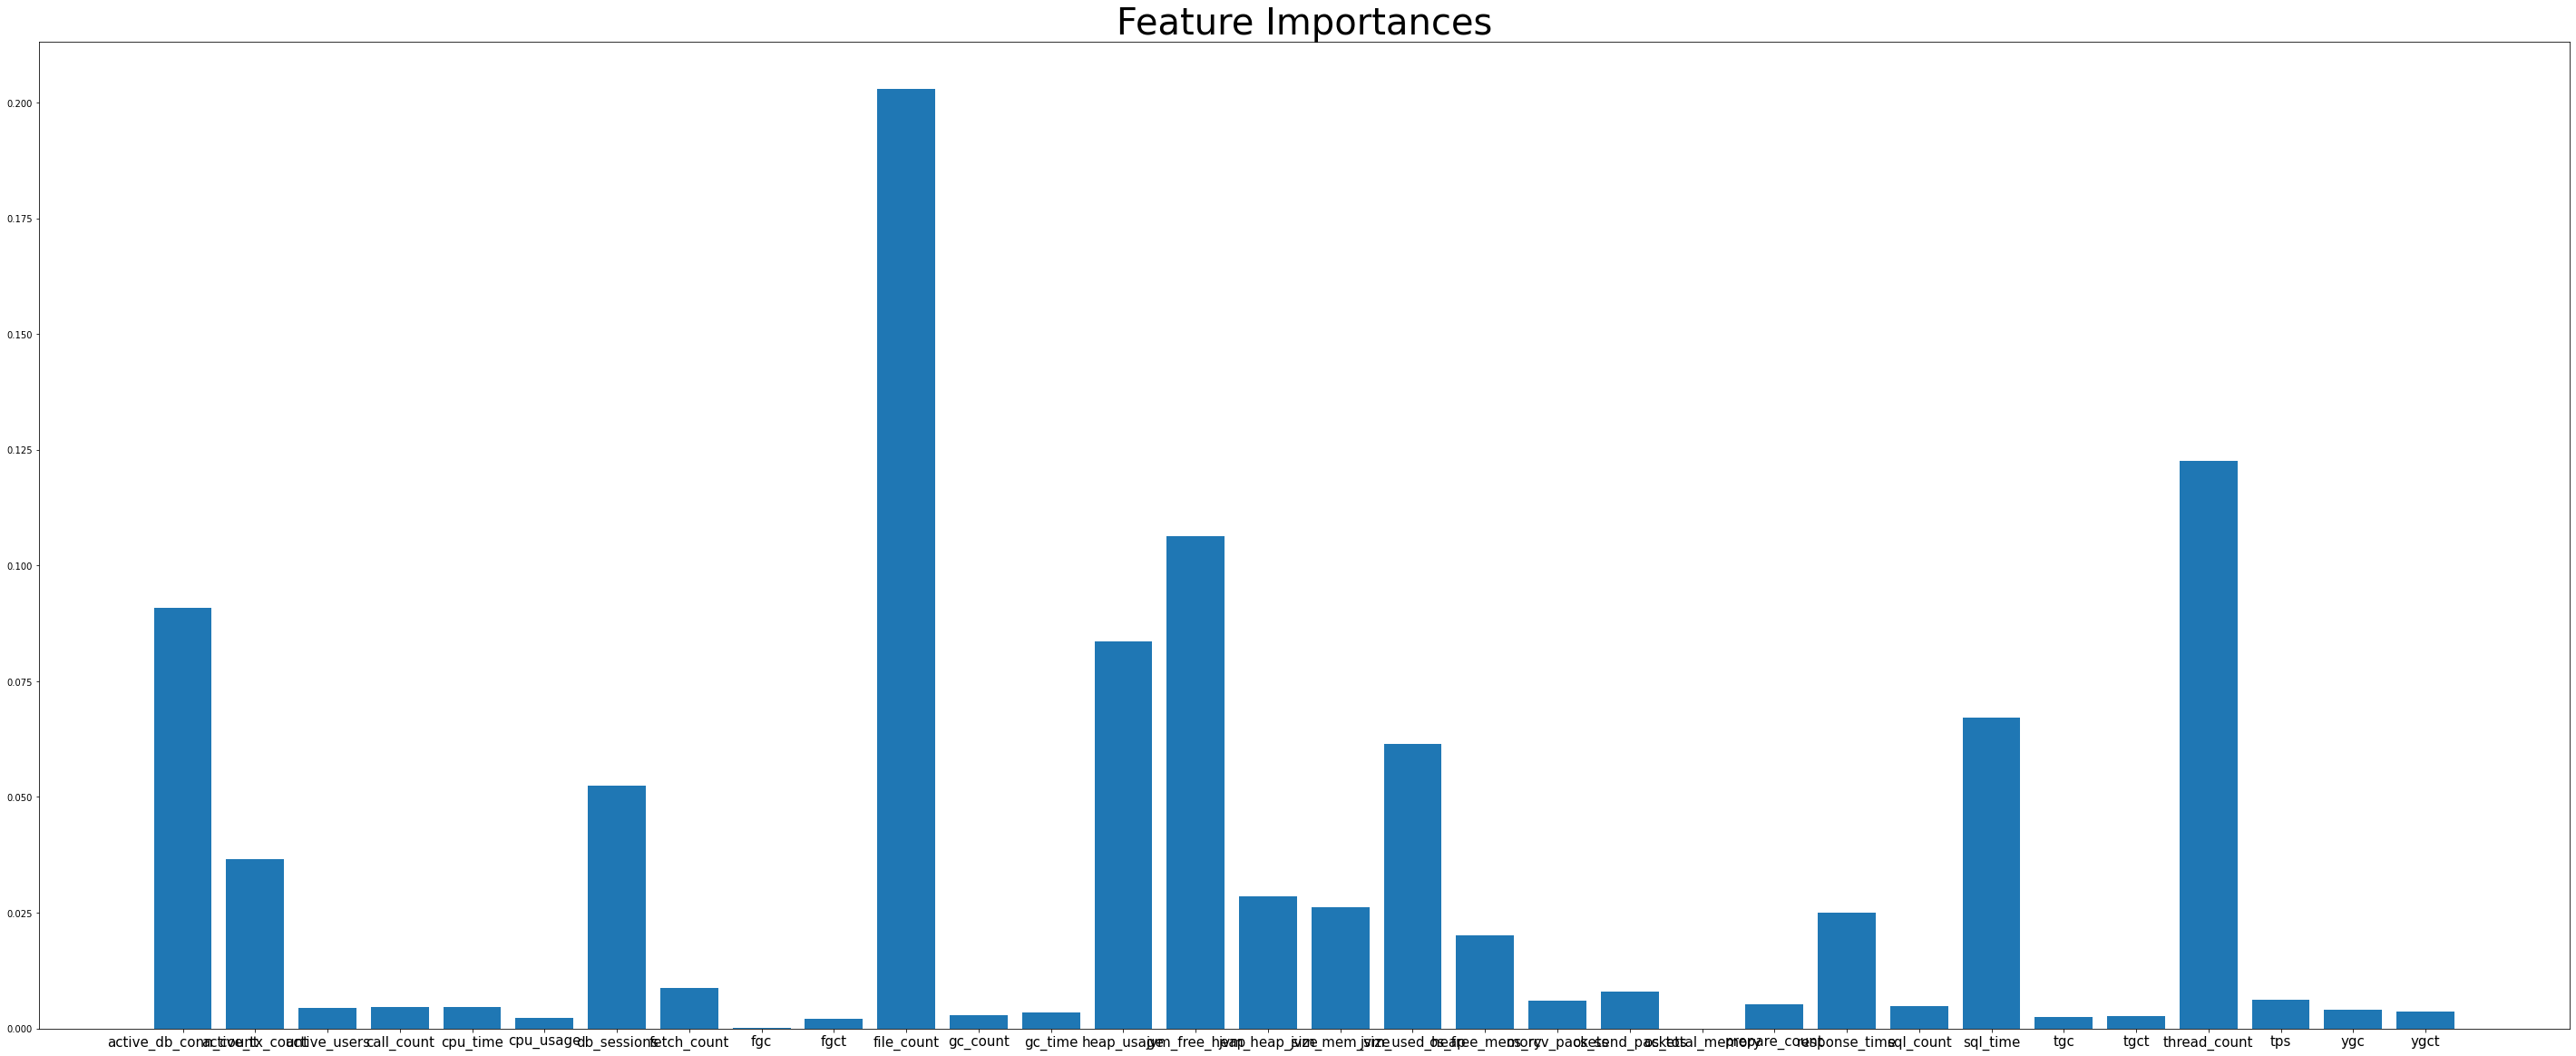

In [47]:
from sklearn.metrics import roc_auc_score
import matplotlib

Y_predict = forest_classifier.predict(X_test)
result = roc_auc_score(np.array(Y_test), np.array(Y_predict))
print('roc_auc_score:', result, '\n')

# random forest feature importances
feature_names = list(X_train.columns)
print(feature_names, '\n')

importances = forest_classifier.feature_importances_
print(np.round(importances, 3))

# plot bar graph for importances
plt.figure(figsize=(50, 20))
plt.bar(np.arange(0, len(importances)), importances)
plt.xticks(np.arange(0, len(importances)), feature_names, fontsize=15)
plt.title('Feature Importances', fontsize=40)
plt.show()


In [57]:
from sklearn.preprocessing import StandardScaler

df_shuffled_sample = df_shuffled.sample(frac=1)
RES_TIMES = df_shuffled_sample[['response_time', 'is_anomaly']].sort_index(ascending=True)
SQL_COUNTS = df_shuffled_sample[['sql_count', 'is_anomaly']].sort_index(ascending=True)

print(RES_TIMES)
print(SQL_COUNTS)

                     response_time  is_anomaly
time                                          
2022-04-01 00:10:00       109.1034           1
2022-04-01 00:19:00       102.0769           1
2022-04-01 00:21:00        52.3333           1
2022-04-01 00:31:00        81.7513           1
2022-04-01 00:32:00      2366.0410           1
...                            ...         ...
2022-07-10 22:40:00        56.7073           0
2022-07-10 22:55:00        28.6494           0
2022-07-10 22:57:00        53.3470           0
2022-07-10 23:48:00        46.1666           0
2022-07-10 23:57:00        63.0294           0

[14391 rows x 2 columns]
                     sql_count  is_anomaly
time                                      
2022-04-01 00:10:00       0.10           1
2022-04-01 00:19:00       0.10           1
2022-04-01 00:21:00       0.10           1
2022-04-01 00:31:00      20.90           1
2022-04-01 00:32:00      15.05           1
...                        ...         ...
2022-07-10 22:40:00

In [58]:
from sklearn.preprocessing import MinMaxScaler

# scale column values
scaler = MinMaxScaler()
RES_TIMES_SCALED = scaler.fit_transform(RES_TIMES.to_numpy().reshape(-1, 2))
print(RES_TIMES_SCALED[:5])

scaler = MinMaxScaler()
SQL_COUNTS_SCALED = scaler.fit_transform(SQL_COUNTS.to_numpy().reshape(-1, 2))
print(SQL_COUNTS_SCALED[:5])


[[0.00858091 1.        ]
 [0.00802828 1.        ]
 [0.00411598 1.        ]
 [0.00642968 1.        ]
 [0.1860875  1.        ]]
[[3.27600328e-04 1.00000000e+00]
 [3.27600328e-04 1.00000000e+00]
 [3.27600328e-04 1.00000000e+00]
 [6.84684685e-02 1.00000000e+00]
 [4.93038493e-02 1.00000000e+00]]


In [67]:
RES_TIMES_SCALED_DF = pd.DataFrame(RES_TIMES_SCALED, index=RES_TIMES.index, columns=['response_time', 'is_anomaly'])
SQL_COUNTS_SCALED_DF = pd.DataFrame(SQL_COUNTS_SCALED, index=SQL_COUNTS.index, columns=['sql_counts', 'is_anomaly'])

print(len(RES_TIMES_SCALED_DF), len(RES_TIMES_SCALED_DF[RES_TIMES_SCALED_DF['is_anomaly'] == 1]))
print(len(SQL_COUNTS_SCALED_DF), len(SQL_COUNTS_SCALED_DF[SQL_COUNTS_SCALED_DF['is_anomaly'] == 1]))

14391 1232
14391 1232


In [70]:
mean = RES_TIMES_SCALED_DF['response_time'].mean()
std = RES_TIMES_SCALED_DF['response_time'].std()
upper = mean + 3*std
lower = mean - 3*std
print(f'upper: {upper}')
print(f'lower: {lower}')

mask = (RES_TIMES_SCALED_DF['response_time'] > upper) | (RES_TIMES_SCALED_DF['response_time'] < lower)
anomaly_res_times = RES_TIMES_SCALED_DF[mask]
anomaly_res_times['is_anomaly'] = 1
# anomaly_res_times.sort_index(inplace=True)

anomaly_res_times

upper: 0.14613218809680983
lower: -0.11525473578664923


time
2022-04-01 00:10:00    0.008581
2022-04-01 00:19:00    0.008028
2022-04-01 00:21:00    0.004116
2022-04-01 00:31:00    0.006430
2022-04-01 00:32:00    0.186087
                         ...   
2022-07-10 22:40:00    0.004460
2022-07-10 22:55:00    0.002253
2022-07-10 22:57:00    0.004196
2022-07-10 23:48:00    0.003631
2022-07-10 23:57:00    0.004957
Name: response_time, Length: 14391, dtype: float64

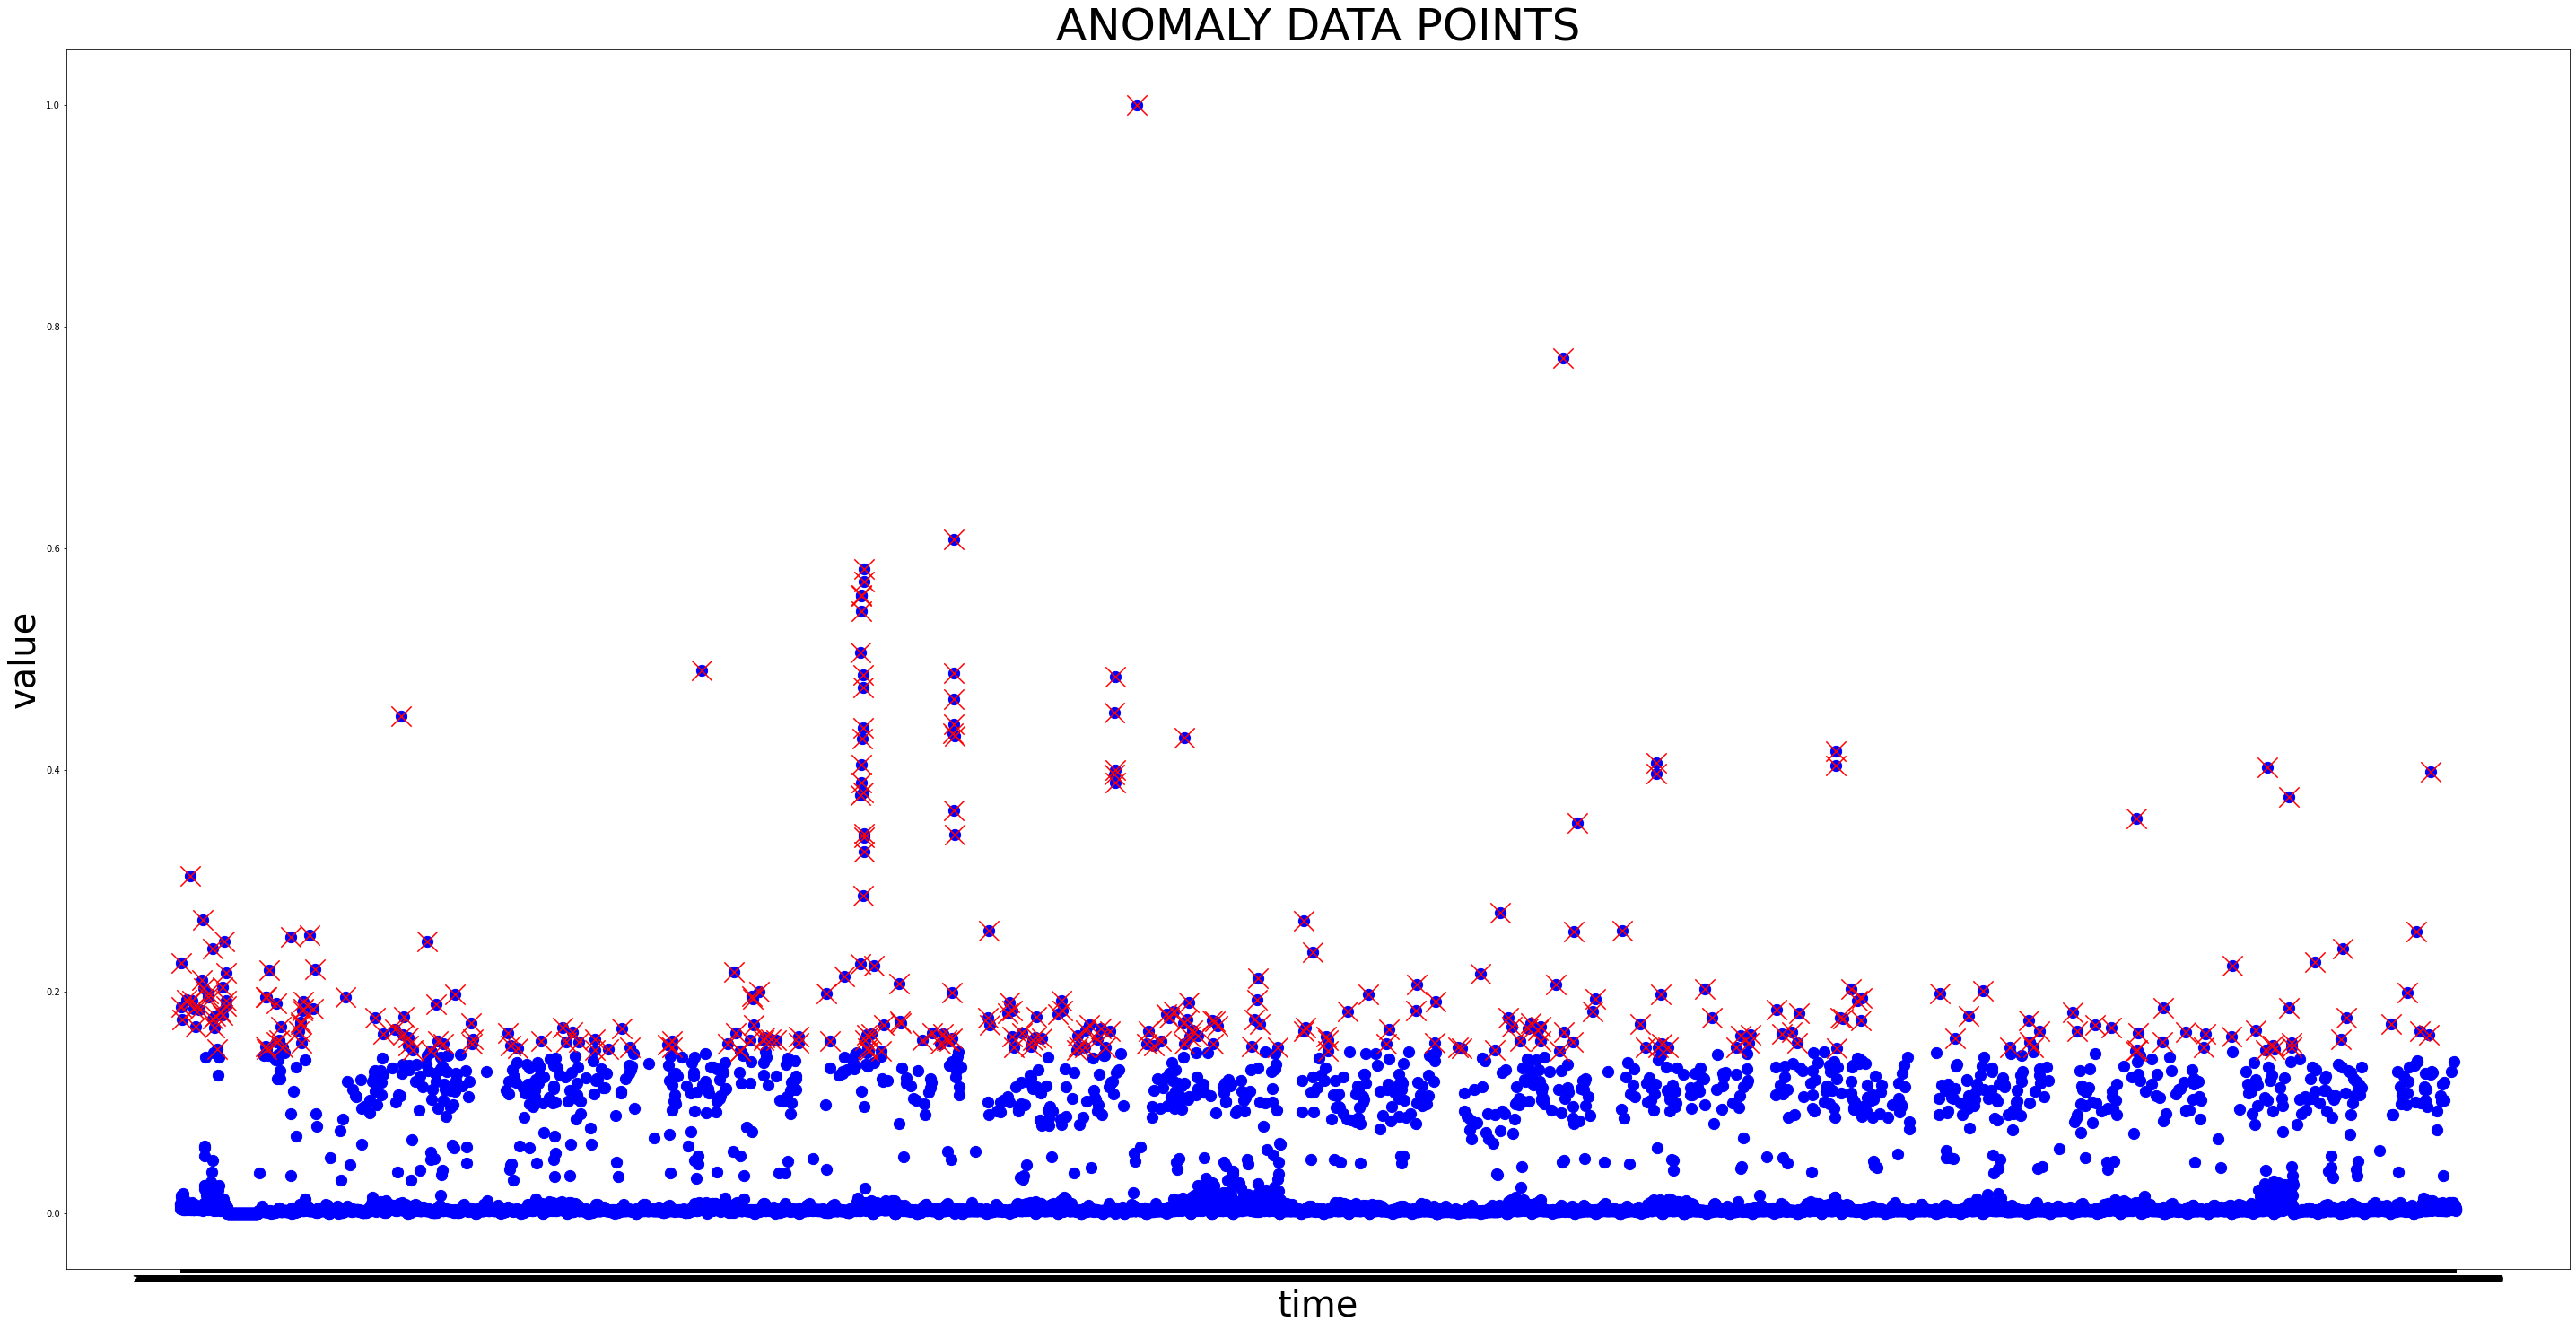

In [71]:
plt.figure(figsize=(50,25))
plt.scatter(RES_TIMES_SCALED_DF.index, RES_TIMES_SCALED_DF.iloc[:, 0], marker='o', c='blue', s=150)
plt.scatter(anomaly_res_times.index, anomaly_res_times.iloc[:, 0], marker='x', c='red', s=500)
plt.xlabel('time', fontsize=40)
plt.ylabel('value', fontsize=40)
plt.title('ANOMALY DATA POINTS', fontsize=50)
plt.show()